# Solar-climate connections over the Common Era 

## Authors

[Feng Zhu](https://scholar.google.com/citations?user=9Etbs9IAAAAJ&hl=en) [![ORCID](https://img.shields.io/badge/ORCID-0000--0002--9969--2953-A6CE39?logo=orcid)](https://orcid.org/0000-0002-9969-2953)
and Deborah Khider [![ORCID](https://img.shields.io/badge/ORCID-0000--0001--7501--8430-A6CE39?logo=orcid)](https://orcid.org/0000-0001-7501-8430)


## Preamble

Variations in solar irradiance have been hypothesized to be responsible for part of the variability in global mean surface temperature (GMST) over the Common Era (the last 2,000 years or so). In this notebook we use [Pyleoclim](https://pyleoclim-util.readthedocs.io/en/latest/) to test this hypothesis using wavelet transform coherency between reconstructions of solar irradiance and GMST.

This notebook reproduces [Fig S16](https://static-content.springer.com/esm/art%3A10.1038%2Fs41561-019-0400-0/MediaObjects/41561_2019_400_MOESM1_ESM.pdf)of PAGES2k Consortium manuscript entitled "Consistent multidecadal variability in global temperature reconstructions and simulations over the Common Era".

Technical Skills Involved:
* Loading data using [pandas](https://pandas.pydata.org)
* Applying and interpreting [Wavelet Transform Coherency](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.wavelet_coherence) analysis


### Data

- Reconstruction of solar irradiance:SATIRE-H dataset ([Vieira et al. 2011](    https://doi.org/10.1051/0004-6361/201015843)), as compiled by [Barboza et al. (2020)](https://doi.org/10.1007/s13253-019-00372-4). 
GMST: Ensemble of [Neukom et al (2019)](https://doi.org/10.1038/s41561-019-0400-0), who applied 7 different statistical methods to the [PAGES 2k database](https://doi.org/10.1038/sdata.2017.88). 

### Reading time
5 min

### Keyword
Pyleoclim; Coherence Analyis; Common Era; Solar irradiance

Let's load the necessary packages:

In [1]:
# load packages
import pyleoclim as pyleo
import pandas as pd
import numpy as np
import os
from matplotlib import gridspec
import matplotlib.pyplot as plt
from tqdm import tqdm

## Exploratory Data Analysis

Let's start by opening the forcing data and GMST reconstruction:

In [2]:
database_path = '../data/'
forcing_filename = 'Neukom2019_forcing.csv'
GMST_filename = 'Neukom2019_GMST_recon_medians_selection.txt'

forcing_df = pd.read_csv(os.path.join(database_path, forcing_filename)) 
GMST_df = pd.read_table(os.path.join(database_path, GMST_filename))

In [3]:
display(GMST_df.head())

,Year,CPS_R-FDR_longcalib,PCR_R-FDR_longcalib,M08_R-FDR_longcalib,PAI_R-FDR_longcalib,OIE_R-FDR_longcalib,BHM_R-FDR_longcalib,LMR_R-FDR_longcalib
0,1,-0.3298,-0.3844,-0.1543,-0.4421,-0.2994,-0.3913,-0.1115
1,2,-0.2933,-0.3744,-0.1962,-0.3966,-0.2530,-0.4667,-0.1084
2,3,-0.2343,-0.3384,-0.2287,-0.2909,-0.1520,-0.4396,-0.1017
3,4,-0.2238,-0.3179,-0.2779,-0.2047,-0.1795,-0.3895,-0.0703
4,5,-0.2823,-0.3474,-0.2609,-0.2533,-0.1047,-0.2997,-0.0910


In [4]:
display(forcing_df.head())

,CO2,volcanic,solar
0,277.45,0.004314,1365.551796
1,277.14,0.004312,1365.544193
2,277.16,0.004312,1365.537762
3,277.16,0.010717,1365.532407
4,277.16,0.009114,1365.528030


Let's import this information into Pyleoclim and plot the corresponding timeseries: 

In [5]:
ts_solar = pyleo.Series(time=GMST_df['Year'].values, 
                        value=forcing_df['solar'].values, 
                        label='Total Solar Irradiance', 
                        time_name='Year', 
                        time_unit='CE', 
                        value_name='TSI', 
                        value_unit=r'W m$^{-2}$')


Time axis values sorted in ascending order


In [6]:
exp_names = list(GMST_df.columns.values)[1:]

ts = {}
for i, exp in enumerate(exp_names):
    ts[exp] = pyleo.Series(time=GMST_df['Year'].values, 
                           value=GMST_df[exp].values, 
                           label=exp, 
                           time_name='Year', 
                           time_unit='CE', 
                           value_name='T anomaly', 
                           value_unit='K')

Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order


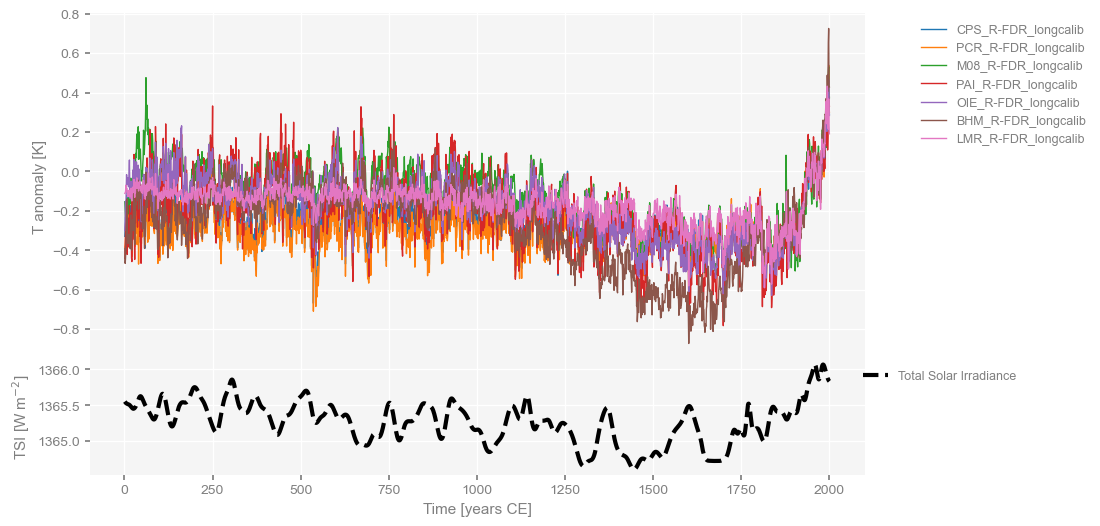

In [7]:
pyleo.set_style('web')
gs = gridspec.GridSpec(4, 1)
gs.update(wspace=0, hspace=0)

fig = plt.figure(figsize=[10, 6])
ax1 = plt.subplot(gs[0:3, :])
for i, exp in enumerate(exp_names):
    ts[exp].plot(ax=ax1,linewidth=1)
ax1.legend(bbox_to_anchor=(1.3, 1.0), loc='upper right')
    
ax2 = plt.subplot(gs[3, :], sharex=ax1)
ts_solar.plot(ax=ax2, linestyle='--', linewidth=3, color='black')    
ax2.legend(bbox_to_anchor=(1.21, 1.0), loc='upper right')

## Wavelet coherency analysis

This uses Pyleoclim's [wavelet coherence method](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.wavelet_coherence). Since the series are evenly-spaced, we will use the [CWT](https://pyleoclim-util.readthedocs.io/en/latest/utils/introduction.html?highlight=cwt#pyleoclim.utils.wavelet.cwt_coherence) method.

In [8]:
scale = np.logspace(1, 11, num=51, base=2)
freq = 1/scale[::-1]
col = {}
for exp in tqdm(exp_names):
    print('Evaluating coherence with '+ exp +'\n')
    col[exp] = ts_solar.wavelet_coherence(ts[exp], 
                settings={'freq':freq}).signif_test(number=200, mute_pbar=True)

  0%|          | 0/7 [00:00<?, ?it/s]

Evaluating coherence with CPS_R-FDR_longcalib



 14%|█▍        | 1/7 [00:09<00:55,  9.17s/it]

Evaluating coherence with PCR_R-FDR_longcalib



 29%|██▊       | 2/7 [00:18<00:46,  9.36s/it]

Evaluating coherence with M08_R-FDR_longcalib



 43%|████▎     | 3/7 [00:28<00:37,  9.45s/it]

Evaluating coherence with PAI_R-FDR_longcalib



 57%|█████▋    | 4/7 [00:38<00:28,  9.59s/it]

Evaluating coherence with OIE_R-FDR_longcalib



 71%|███████▏  | 5/7 [00:47<00:19,  9.67s/it]

Evaluating coherence with BHM_R-FDR_longcalib



 86%|████████▌ | 6/7 [00:57<00:09,  9.77s/it]

Evaluating coherence with LMR_R-FDR_longcalib



100%|██████████| 7/7 [01:07<00:00,  9.60s/it]


We can now plot the results for each reconstruction. Colors indicate the level of coherency, while arrows show the phase angle (right = 0°, left = 180°, top = 90°, bottom = 270°, with intermediate directions representing angles in between).

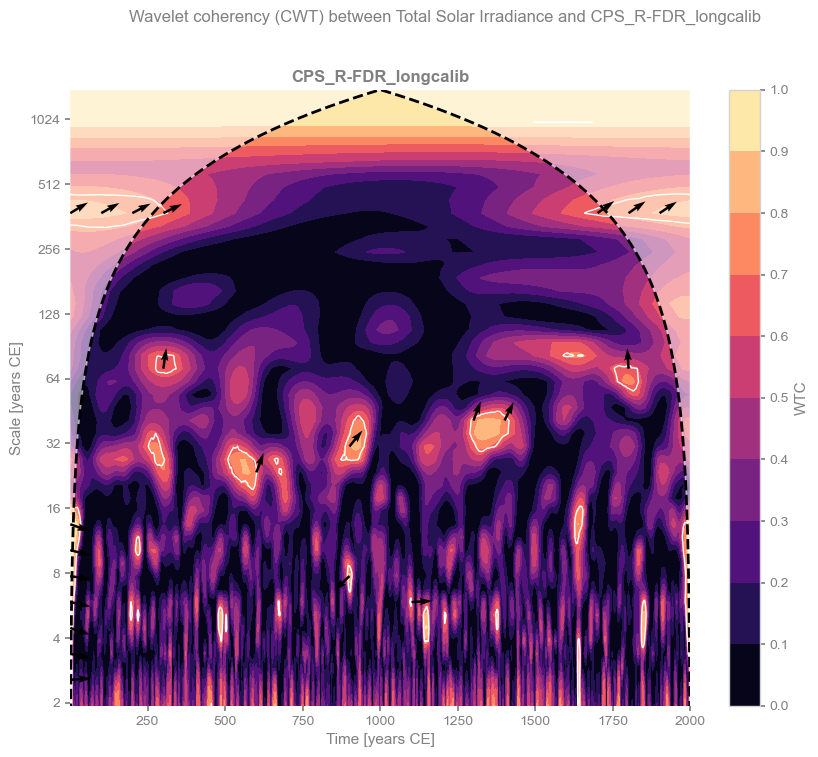

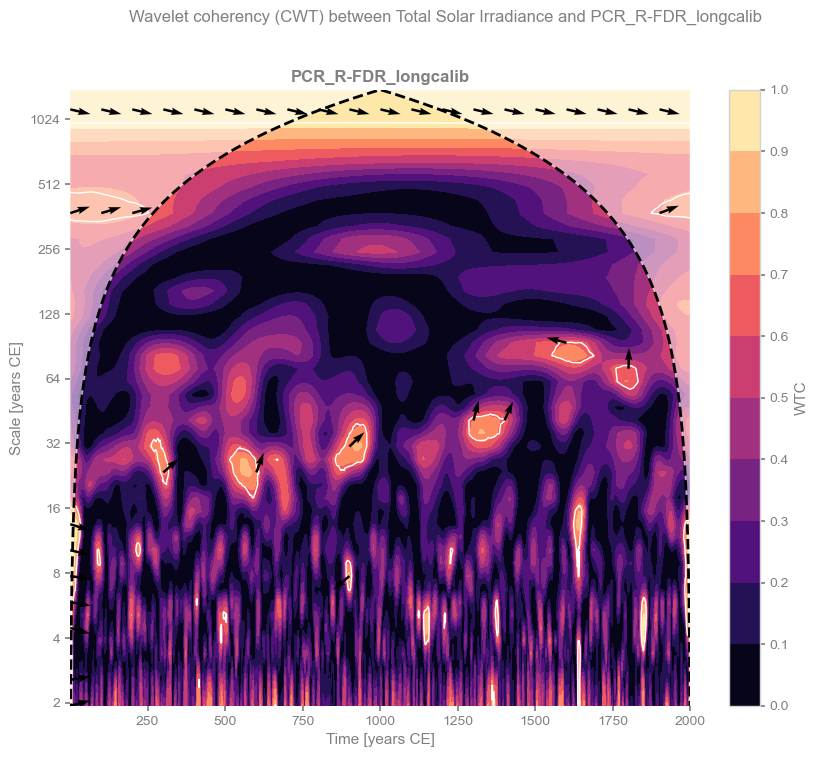

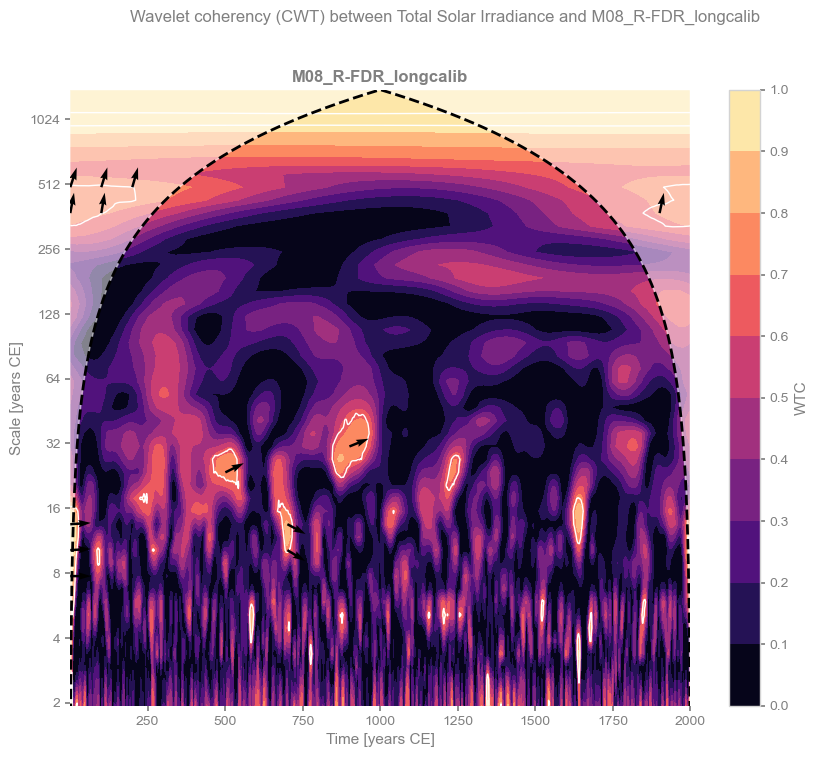

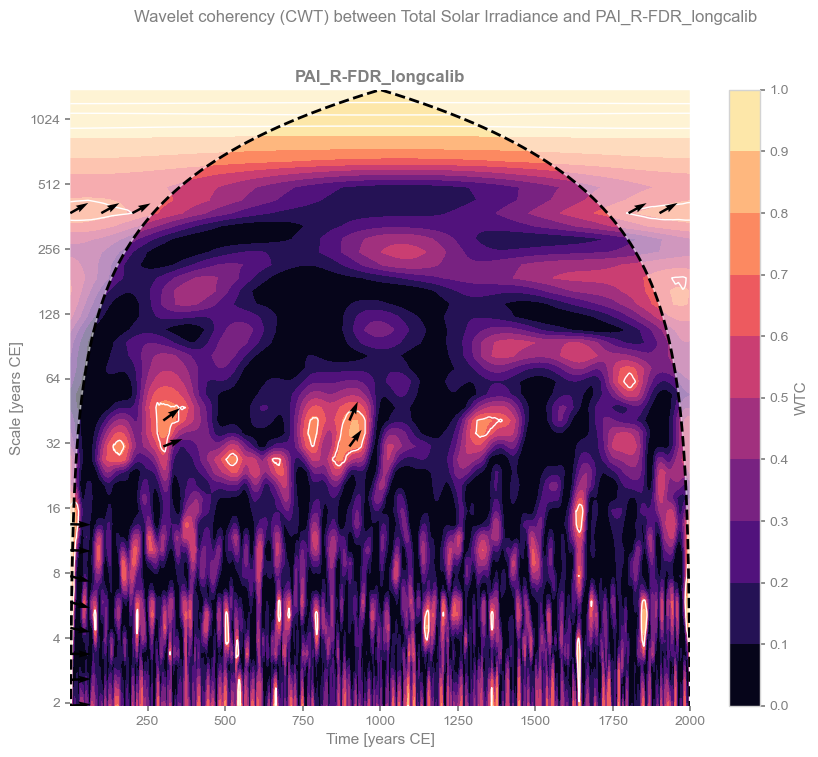

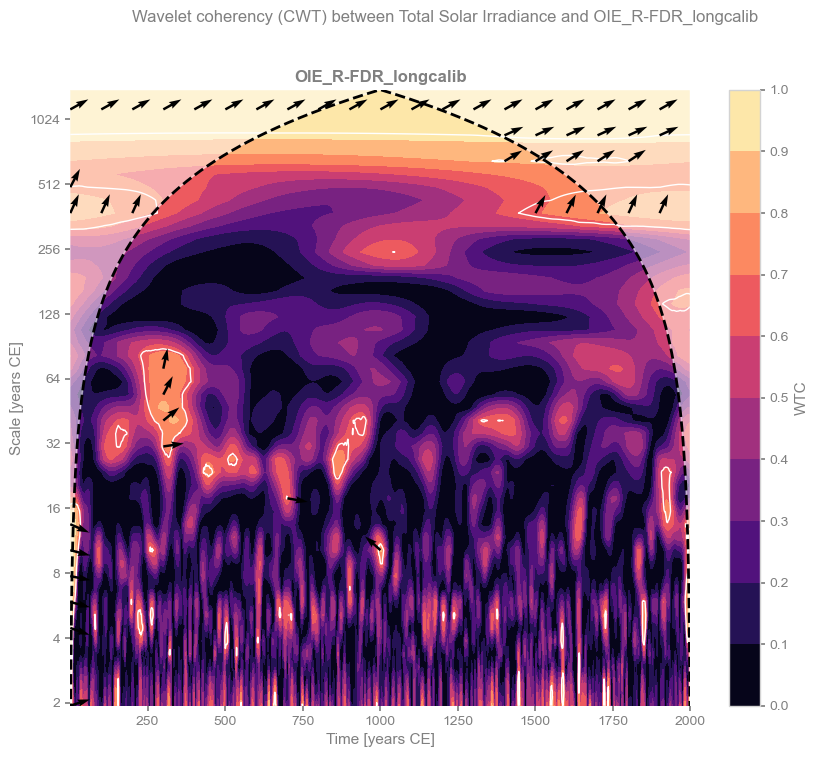

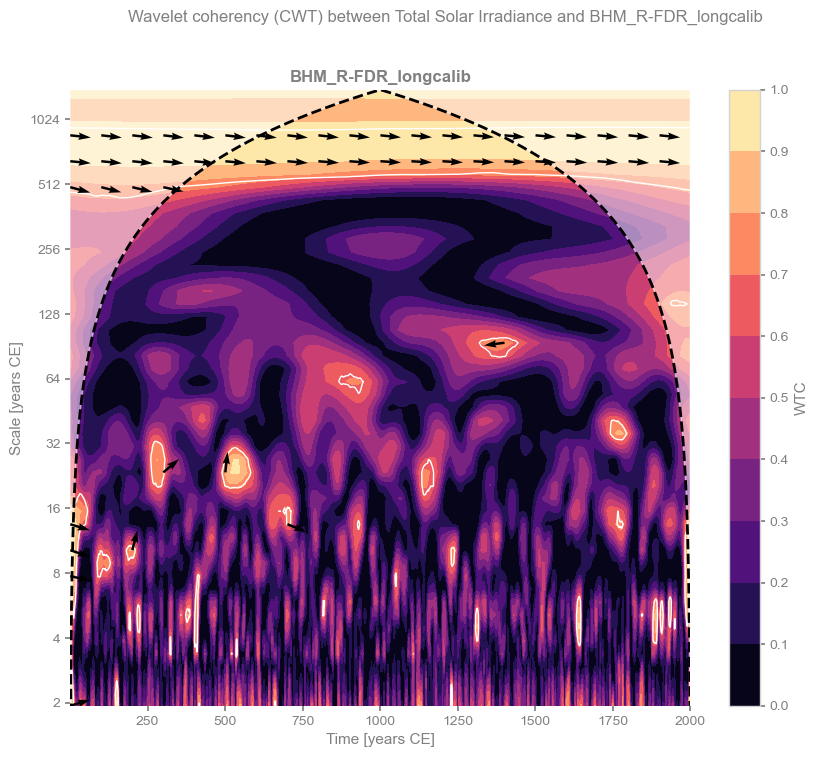

In [10]:
period_ticks = np.logspace(1, 11, num=11, base=2)
for exp in exp_names:
    fig, ax = col[exp].plot(yticks=period_ticks)
    ax.set_title(exp, fontweight='bold')
    
pyleo.closefig()

In some cases, there is a hint of an in-phase relationship (high coherency and phase angles close to 0°) at periods longer than 500 years. However, this signal lies near the cone of influence (the region of the scalogram affected by edge effects) and does not appear significant when tested against a red-noise (AR(1)) benchmark. The main exception is the BHM reconstruction from [Barboza et al. (2019)](https://doi.org/10.1007/s13253-019-00372-4), which explicitly includes solar forcing as a predictor. It is therefore unsurprising that this reconstruction shows coherence with solar variability, although the original study demonstrates that the signal is weak. Overall, we find no evidence for a robust solar influence on climate in these reconstructions.